<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/08_pytorch_paper_replicating_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 08. PyTorch Paper Replicating Exercises

Welcome to the 08. PyTorch Paper Replicating exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/tjpW_BY8y3g) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [08. PyTorch Paper Replicating](https://www.learnpytorch.io/08_pytorch_paper_replicating/). 

In [2]:
# Continue with regular imports
import torch
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

from torchinfo import summary

from going_modular import data_setup, engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

Want to download the data we've been using in PyTorch Paper Replicating: https://www.learnpytorch.io/08_pytorch_paper_replicating/#1-get-data

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [6]:
# Create image size (from Table 3 in the ViT paper) 
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])           
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1fd0b255400>,
 ['pizza', 'steak', 'sushi'])

In [12]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

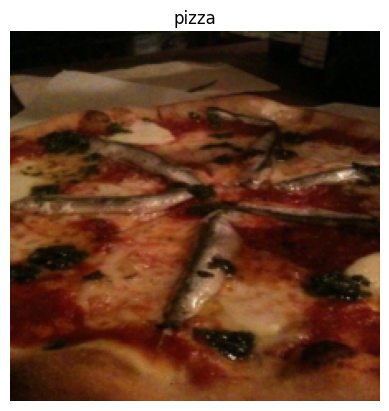

In [14]:
# Plot image with matplotlib
plt.imshow(
    image.permute(1, 2, 0)
)  # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

## 1. Replicate the ViT architecture we created with in-built [PyTorch transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

* You'll want to look into replacing our `TransformerEncoderBlock()` class with [`torch.nn.TransformerEncoderLayer()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html#torch.nn.TransformerEncoderLayer) (these contain the same layers as our custom blocks). 
* You can stack `torch.nn.TransformerEncoderLayer()`'s on top of each other with [`torch.nn.TransformerEncoder()`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html#torch.nn.TransformerEncoder).

In [24]:
%%writefile vit.py
import torch
from torch import nn

class ViT(nn.Module):
    def __init__(
        self,
        image_size: int,
        patch_size: int,
        num_classes: int,
        dim: int,
        depth: int,
        heads: int,
        mlp_dim: int,
        channels: int = 3,
        dropout: float = 0.0,
        emb_dropout: float = 0.0,
    ):
        super(ViT, self).__init__()
        assert (
            image_size % patch_size == 0
        ), "Image dimensions must be divisible by the patch size."

        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size**2

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim,
                nhead=heads,
                dim_feedforward=mlp_dim,
                dropout=dropout,
                activation="gelu",
            ),
            num_layers=depth,
        )

        self.classifier = nn.Sequential(nn.LayerNorm(dim), nn.Linear(dim, num_classes))

    def forward(self, x):
        batch_size = x.shape(0)

        # Add class token to the beginning
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)

        # Linear embedding of patches
        x = self.patch_to_embedding(x)

        x = torch.cat((cls_tokens, x), dim=1)

        # Add positional embedding
        x += self.pos_embedding
        x = self.dropout(x)

        # Pass through transformer
        x = self.transformer(x)

        # Take the class token output
        x = self.classifier(x[:, 0])

        return x

Overwriting vit.py


## 2. Turn the custom ViT architecture we created into a Python script, for example, `vit.py`.

* You should be able to import an entire ViT model using something like`from vit import ViT`.
* We covered the art of turning code cells into Python scrips in [05. PyTorch Going Modular](https://www.learnpytorch.io/05_pytorch_going_modular/). 


In [25]:
from vit import ViT

## 3. Train a pretrained ViT feature extractor model (like the one we made in [08. PyTorch Paper Replicating section 10](https://www.learnpytorch.io/08_pytorch_paper_replicating/#10-bring-in-pretrained-vit-from-torchvisionmodels-on-same-dataset)) on 20% of the pizza, steak and sushi data like the dataset we used in [07. PyTorch Experiment Tracking section 7.3](https://www.learnpytorch.io/07_pytorch_experiment_tracking/#73-download-different-datasets) 
* See how it performs compared to the EffNetB2 model we compared it to in [08. PyTorch Paper Replicating section 10.6](https://www.learnpytorch.io/08_pytorch_paper_replicating/#106-save-feature-extractor-vit-model-and-check-file-size).

In [8]:
# The following requires torch v0.12+ and torchvision v0.13+
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.8.0+cu126
0.23.0+cu126


'cuda'

In [9]:
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

for param in pretrained_vit.parameters():
    param.requires_grad = False

set_seeds()

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(
    device
)

In [31]:
summary(
    pretrained_vit,
    input_size=(BATCH_SIZE, 3, IMG_SIZE, IMG_SIZE),
    col_names=["input_size", "output_size", "num_params", "trainable"],
)

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [32, 3, 224, 224]         [32, 3]                   768                       Partial
├─Conv2d: 1-1                                 [32, 3, 224, 224]         [32, 768, 14, 14]         (590,592)                 False
├─Encoder: 1-2                                [32, 197, 768]            [32, 197, 768]            151,296                   False
│    └─Dropout: 2-1                           [32, 197, 768]            [32, 197, 768]            --                        --
│    └─Sequential: 2-2                        [32, 197, 768]            [32, 197, 768]            --                        False
│    │    └─EncoderBlock: 3-1                 [32, 197, 768]            [32, 197, 768]            (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [32, 197, 768]            [32, 197, 768] 

In [10]:
from helper_functions import download_data

image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi",
)

train_dir = image_path / "train"
test_dir = image_path / "test"

[INFO] data\pizza_steak_sushi directory exists, skipping download.


In [11]:
pretrained_vit_transforms = pretrained_vit_weights.transforms()
pretrained_vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_transforms,  # use pretrained ViT transforms
    batch_size=BATCH_SIZE,
)

In [13]:
optimizer = torch.optim.Adam(pretrained_vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

set_seeds()
pretrained_vit_results = engine.train(
    model=pretrained_vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


In [14]:
from going_modular import utils

utils.save_model(
    model=pretrained_vit,
    target_dir="models",
    model_name="pretrained_vit_pizza_steak_sushi.pth",
)

[INFO] Saving model to: models\pretrained_vit_pizza_steak_sushi.pth


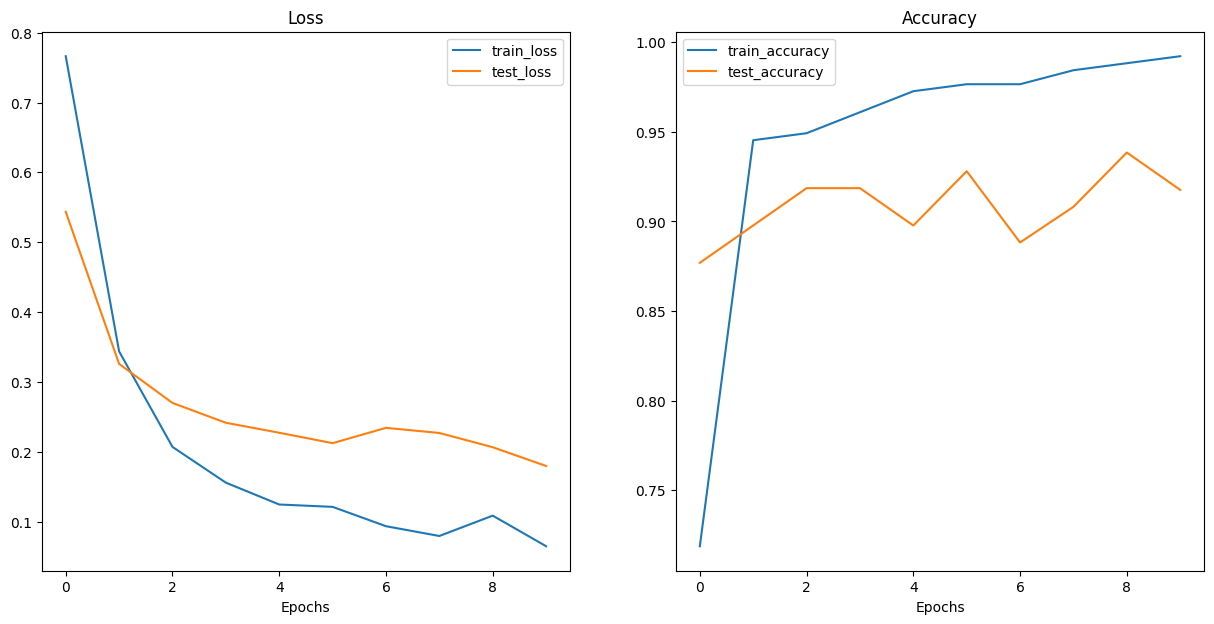

In [37]:
plot_loss_curves(pretrained_vit_results)

## 4. Try repeating the steps from excercise 3 but this time use the "`ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1`" pretrained weights from [`torchvision.models.vit_b_16()`](https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16).
* Note: ViT pretrained with SWAG weights has a minimum input image size of (384, 384), though this is accessible in the weights `.transforms()` method.

In [1]:
pretrained_vit_weights_v1 = torchvision.models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1
pretrained_vit_v1 = torchvision.models.vit_b_16(weights=pretrained_vit_weights_v1).to(
    device
)

for param in pretrained_vit_v1.parameters():
    param.requires_grad = False

pretrained_vit_v1.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(
    device
)

pretrained_vit_v1_transforms = pretrained_vit_weights_v1.transforms()
pretrained_vit_v1_transforms

NameError: name 'torchvision' is not defined

In [41]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=pretrained_vit_v1_transforms,  # use pretrained ViT transforms
    batch_size=BATCH_SIZE,
)

In [42]:
optimizer = torch.optim.Adam(pretrained_vit_v1.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

pretrained_vit_v1_results = engine.train(
    model=pretrained_vit_v1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5064 | train_acc: 0.8281 | test_loss: 0.1288 | test_acc: 0.9792
Epoch: 2 | train_loss: 0.0927 | train_acc: 0.9805 | test_loss: 0.0924 | test_acc: 0.9489
Epoch: 3 | train_loss: 0.0598 | train_acc: 0.9844 | test_loss: 0.0775 | test_acc: 0.9792
Epoch: 4 | train_loss: 0.0440 | train_acc: 0.9883 | test_loss: 0.0646 | test_acc: 0.9792
Epoch: 5 | train_loss: 0.0307 | train_acc: 0.9922 | test_loss: 0.0571 | test_acc: 0.9792
Epoch: 6 | train_loss: 0.0232 | train_acc: 0.9961 | test_loss: 0.0544 | test_acc: 0.9792
Epoch: 7 | train_loss: 0.0173 | train_acc: 0.9961 | test_loss: 0.0526 | test_acc: 0.9792
Epoch: 8 | train_loss: 0.0146 | train_acc: 0.9961 | test_loss: 0.0523 | test_acc: 0.9792
Epoch: 9 | train_loss: 0.0152 | train_acc: 1.0000 | test_loss: 0.0516 | test_acc: 0.9792
Epoch: 10 | train_loss: 0.0098 | train_acc: 1.0000 | test_loss: 0.0523 | test_acc: 0.9792


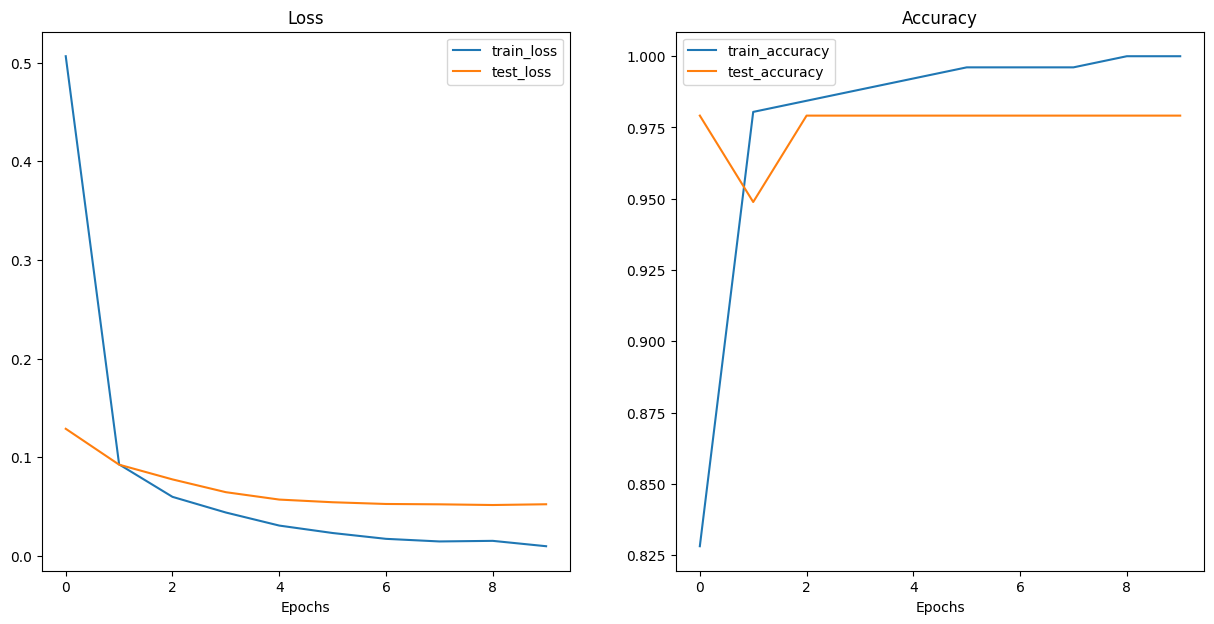

In [43]:
plot_loss_curves(pretrained_vit_v1_results)

# 5. Our custom ViT model architecture closely mimics that of the ViT paper, however, our training recipe misses a few things. 
* Research some of the following topics from Table 3 in the ViT paper that we miss and write a sentence about each and how it might help with training:
    * **ImageNet-21k pretraining** 
    * **Learning rate warmup** 
    * **Learning rate decay** 
    * **Gradient clipping** 

pretraining:
Learning rate warmup: 由于刚开始训练时,模型的权重(weights)是随机初始化的，此时若选择一个较大的学习率,可能带来模型的不稳 定(振荡)，选择Warmup预热学习率的方式，可以使得开始训练的几个epoch或者一些step内学习率较小,在预热的小学习率下，模型可以慢慢趋于稳定,等模型相对稳定后再选择预先设置的学习率进行训练,使得模型收敛速度变 得更快，模型效果更佳。
Learning rate decay：为了防止学习率过大，在收敛到全局最优点的时候会来回摆荡，所以要让学习率随着训练轮数不断按指数级下降，收敛梯度下降的学习步长。
Gradient clipping：梯度裁剪通过设定一个阈值来限制梯度的大小。如果梯度超过这个阈值，它们将被缩放至阈值以内，从而避免了大的权重更新。这样做有助于稳定训练过程，尤其是在训练复杂的深度学习模型时。